In [1]:
from adaIN_model import *
import cv2 as cv

In [2]:
#set up adaIN model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

IMAGE_SIZE = 96

encoder = get_encoder(IMAGE_SIZE)
loss_net = get_loss_net(IMAGE_SIZE)
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=2.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

In [3]:
#get trained weights
weights_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\style_checkpoints\litter_style_checkpoint"
model.load_weights(weights_path)

In [4]:
#load some samples
dashlit_samples = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\dashlit-transfer"
taco_samples = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\taco-transfer"

def getSamples(p,count):
    samps = os.listdir(p)[:count]
    samps = [os.path.join(p,samp) for samp in samps]
    im_array = []
    for samp in samps:
        load_resize = decode_and_resize(samp,IMAGE_SIZE)
        im_array.append(tf.expand_dims(load_resize,0))
    return im_array

In [5]:
dashlit_loaded = getSamples(dashlit_samples,30)
taco_loaded = getSamples(taco_samples,30)

In [6]:
print(taco_loaded[0].shape)

(1, 96, 96, 3)


In [7]:
def transferStyle(style,content):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    
    return reconstructed_image

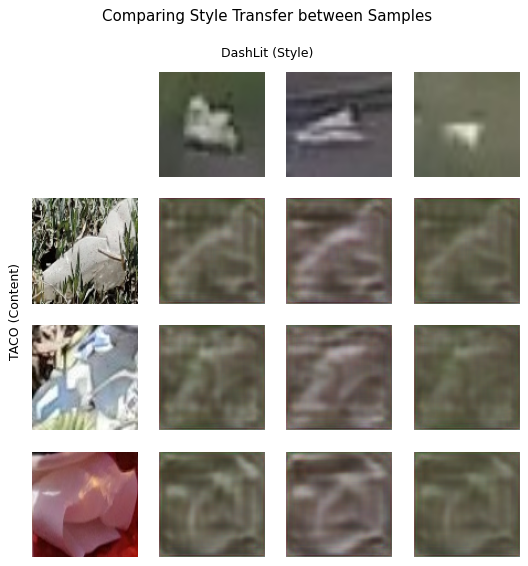

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(7, 7), dpi=90, sharey=False, squeeze= True)
ax = ax.flatten()
[az.axis("off") for az in np.ravel(ax)]

fig.suptitle("Comparing Style Transfer between Samples")
fig.text(0.5, 0.92, 'DashLit (Style)', ha='center', va='top')
fig.text(0.1, 0.5, 'TACO (Content)', ha='center', va='center', rotation='vertical')

#first row
ax[0].imshow(np.full((10, 10, 3), (255,255,255), dtype=np.uint8) / 255.0)
ax[1].imshow(tf.squeeze(dashlit_loaded[0]))
ax[2].imshow(tf.squeeze(dashlit_loaded[5]))
ax[3].imshow(tf.squeeze(dashlit_loaded[10]))

#first column
ax[4].imshow(tf.squeeze(taco_loaded[0]))
ax[8].imshow(tf.squeeze(taco_loaded[5]))
ax[12].imshow(tf.squeeze(taco_loaded[10]))

#second row (results)
ax[5].imshow(tf.squeeze(transferStyle(dashlit_loaded[0],taco_loaded[0])))
ax[6].imshow(tf.squeeze(transferStyle(dashlit_loaded[5],taco_loaded[0])))
ax[7].imshow(tf.squeeze(transferStyle(dashlit_loaded[10],taco_loaded[0])))

#third row (results)
ax[9].imshow(tf.squeeze(transferStyle(dashlit_loaded[0],taco_loaded[5])))
ax[10].imshow(tf.squeeze(transferStyle(dashlit_loaded[5],taco_loaded[5])))
ax[11].imshow(tf.squeeze(transferStyle(dashlit_loaded[10],taco_loaded[5])))

#fourth row (results)
ax[13].imshow(tf.squeeze(transferStyle(dashlit_loaded[0],taco_loaded[10])))
ax[14].imshow(tf.squeeze(transferStyle(dashlit_loaded[5],taco_loaded[10])))
ax[15].imshow(tf.squeeze(transferStyle(dashlit_loaded[10],taco_loaded[10])))

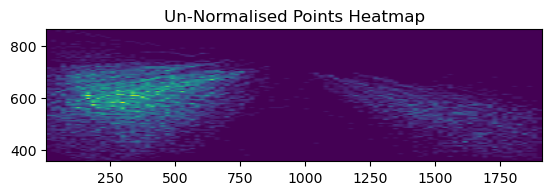

In [9]:
#cut out and copy-paste
#Place in random points from training data samples

#get verge image
verge_p = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg\20220605231413_000097_Trim_frame2.jpg"
verge = cv.cvtColor(cv.imread(verge_p),cv.COLOR_BGR2RGB)
vh = verge.shape[0]; vw = verge.shape[1]
#Load points
import pandas as pd
labelCSV = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\Training02.csv"

centx = []
centy = []

#annotations file
df_antt = pd.read_csv(labelCSV)

xmin = df_antt["xmin"].values
ymin = df_antt["ymin"].values
xmax = df_antt["xmax"].values
ymax = df_antt["ymax"].values
width = df_antt["width"].values #width and height of IMAGES
height = df_antt["height"].values

for i, name in enumerate(xmin):
    xcen = float((xmin[i] + xmax[i])) / 2 / width[i] #normalise bboxes for yolo according to image size (YOLO is in format <class> <x centroid> <y centroid> <bb width> <bb height>)
    ycen = float((ymin[i] + ymax[i])) / 2 / height[i]
    
    centx.append(xcen)
    centy.append(ycen)
    
    
###note: currently uses center points for downstream "top left bbox" placement

#modify points for verge dimensions
newCentx = np.multiply(centx, vw)
newCenty = np.multiply(centy, vh)

heatmap, xedges, yedges = np.histogram2d(newCentx, newCenty, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = plt.subplots()
plt.clf()
plt.imshow(heatmap.T, extent=extent)
plt.title("Un-Normalised Points Heatmap")

ax.set_xlim(vh)
ax.set_ylim(vw)
plt.show()

In [10]:
def getTaco(p, imIds):   
    ann_path = os.path.join(p, "annotations.json")
    coco = COCO(ann_path)
    
    litIms = []
    litMasks = []
    fnames = []
    
    for imId in imIds: #for each image selected
        #get image object from coco annotations
        img = coco.imgs[imId]
        
        #get file name and join it to data path
        imp = os.path.join(p, img['file_name'])
        fnames.append(img['file_name'])
        
        #get category ids
        cat_ids = coco.getCatIds()
        #get annotation ids
        anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        
        #load taco image
        im = cv.cvtColor(cv.imread(imp),cv.COLOR_BGR2RGB)
        
        #for each annotation....
        
        for i, ann in enumerate (anns):
            mask = coco.annToMask(anns[i])

            #crop image and mask
            img_h,img_w,c = im.shape


            [x,y,w,h] = anns[i]['bbox']
            cropped_img = im[int(y):int(y+h), int(x):int(x+w),  :]
            cropped_mask = mask[int(y):int(y+h), int(x):int(x+w)]

            #Cutout rubbish using mask
            cut_img = cv.bitwise_and(cropped_img,cropped_img,mask = cropped_mask)
        
        #add to array of samples
        litIms.append(cut_img)
        litMasks.append(cropped_mask)
        
    return fnames, litIms, litMasks

    
#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)
    
    new_w = dim[0]
    new_h = dim[1]
    
    # return the resized image
    return resized, new_w, new_h

#combine litter and subsection of an image -> x1 and y1 are top-left of litter bounding box (top left cropped sample)
def combine(litter_im, litter_mask, verge, x1, y1, rotate = False):
    #Add images together
    
    #if rotate ==True, randomly rotate (possibility of no rotation '0' degrees)
    if rotate:
        angle = random.choice([-90,0,90,180])
        if angle == -90:
            litter_im = cv.rotate(litter_im,cv.ROTATE_90_COUNTERCLOCKWISE)
            litter_mask = cv.rotate(litter_mask,cv.ROTATE_90_COUNTERCLOCKWISE)
        elif angle == 90:
            litter_im = cv.rotate(litter_im,cv.ROTATE_90_CLOCKWISE)
            litter_mask = cv.rotate(litter_mask,cv.ROTATE_90_CLOCKWISE)
        elif angle ==180:
            litter_im = cv.rotate(litter_im,cv.ROTATE_180)
            litter_mask = cv.rotate(litter_mask,cv.ROTATE_180)
    
    #https://www.binarystudy.com/2022/09/How-to-add-subtract-different-size-images-using-OpenCV-Python.html#:~:text=Alternatively%20you%20can%20use%20cv2.addWeighted%20%28%29%20to%20add,cv2.addWeighted%20%28img11%2C%200.3%2C%20img22%2C%200.7%2C%200%29%20plt.imshow%20%28img_add%29

    # Find the minimum height and width of the two images
    min_height = litter_im.shape[0]
    min_width = litter_im.shape[1]

    # Crop images with minimum height and width
    foreground = litter_im *255 #NEED to multiply by 255 to show in regular rgb verge data
    background = verge[y1-min_height:y1,x1:x1+min_width]

    (Rb, Gb, Bb) = cv.split(background)
    (Rf, Gf, Bf) = cv.split(foreground)


    #invert mask
    inv_mask = 1-litter_mask


    #In each colour channel, cut out mask and add foreground channels
    Rn = cv.bitwise_and(Rb,Rb,mask=inv_mask) + Rf
    Gn = cv.bitwise_and(Gb,Gb,mask=inv_mask) + Gf
    Bn = cv.bitwise_and(Bb,Bb,mask=inv_mask) + Bf
    
    #plt.imshow(Rf)
    #merge channels back together
    merged = cv.merge([Rn,Gn,Bn])
    
    verge[y1-min_height:y1,x1:x1+min_width] = merged
    
    return verge, min_width, min_height


In [11]:
from pycocotools.coco import COCO
taco_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste/TACO/TACO-master/data"
fnames, ims, masks  = getTaco(taco_path,[0])

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [12]:
#Converts file name/path back into 
def convert_to_transfer_name(fname):
    new_im_name = fname.split("/")[0] + "_" + fname.split("/")[1].split(".")[0] + "_taco_transfer.jpg"
    return new_im_name

print(fnames[0], convert_to_transfer_name(fnames[0]))

batch_1/000006.jpg batch_1_000006_taco_transfer.jpg


In [13]:
#load taco mask, get resize mask, get relevant resized image
taco_transfer_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\taco-transfer"
dashlit_transfer_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\dashlit-transfer"

(1322, 447)


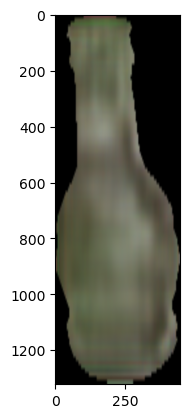

In [14]:
import random

#get mask, im name and relevant converted image

m_dim = masks[0].shape # save original shape
print(m_dim)

#resize mask for style transfer
new_mask= cv.resize(masks[0], (96,96))

#get name of taco sample in transfer dataset
new_im_name = convert_to_transfer_name(fnames[0])
new_taco = os.path.join(taco_transfer_path,new_im_name)
content_im = tf.expand_dims(decode_and_resize(new_taco,96),0)

#get random dashlit sample
style_index = random.randint(0,len(os.listdir(dashlit_transfer_path)))
style_im = tf.expand_dims(decode_and_resize(os.path.join(dashlit_transfer_path,os.listdir(dashlit_transfer_path)[style_index]),96),0)

#transfer style
nst_im = transferStyle(style_im, content_im)
nst_im = tf.squeeze(nst_im)
nst_im = np.array(nst_im)


#cut image using mask and resize back to original
cut_img = cv.bitwise_and(nst_im,nst_im,mask = new_mask)
cut_resized = cv.resize(cut_img, (m_dim[1],m_dim[0]))
plt.imshow(cut_resized)

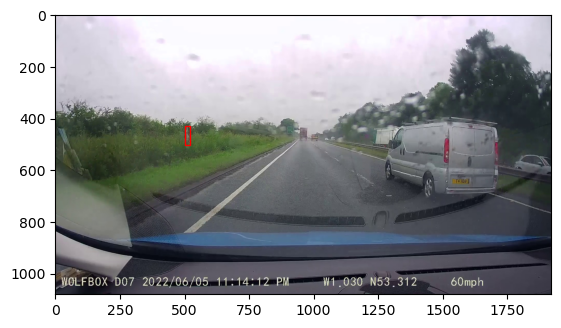

In [15]:
import matplotlib.patches as patches
verge = cv.cvtColor(cv.imread(verge_p),cv.COLOR_BGR2RGB)

fig, ax = plt.subplots()

#resize for context
context_cut, w, h = image_resize(cut_resized,height = 70)

context_mask, _, _ = image_resize(masks[0], height = 70)

merged,nw,nh = combine(context_cut, context_mask, verge, 500,500)

rect = patches.Rectangle((500, 500-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')




ax.add_patch(rect)


plt.imshow(merged)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


(-0.5, 1919.5, 1079.5, -0.5)

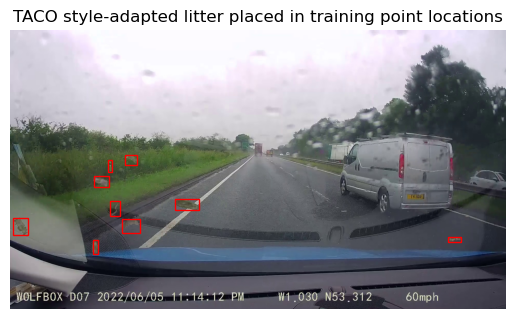

In [16]:
#Try with many samples
fnames, ims, masks  = getTaco(taco_path,[0,1,2,3,4,5,6,7,8])



verge = cv.cvtColor(cv.imread(verge_p),cv.COLOR_BGR2RGB)

fig, ax = plt.subplots()

for i in range(0,len(masks)):
    #get mask, im name and relevant converted image

    m_dim = masks[i].shape # save original shape

    #resize mask for style transfer
    new_mask= cv.resize(masks[i], (96,96))

    #get name of taco sample in transfer dataset
    new_im_name = convert_to_transfer_name(fnames[i])
    new_taco = os.path.join(taco_transfer_path,new_im_name)
    content_im = tf.expand_dims(decode_and_resize(new_taco,96),0)

    #get random dashlit sample
    style_index = random.randint(0,len(os.listdir(dashlit_transfer_path)))
    style_im = tf.expand_dims(decode_and_resize(os.path.join(dashlit_transfer_path,os.listdir(dashlit_transfer_path)[style_index]),96),0)

    #transfer style
    nst_im = transferStyle(style_im, content_im)
    nst_im = tf.squeeze(nst_im)
    nst_im = np.array(nst_im)


    #cut image using mask and resize back to original
    cut_img = cv.bitwise_and(nst_im,nst_im,mask = new_mask)
    cut_resized = cv.resize(cut_img, (m_dim[1],m_dim[0]))

    #resize for context

    pointlen = len(newCentx)


    new_lit_height = random.randint(30,70)# height for litter resizing

    #resize litter to height 100
    context_cut, w , h = image_resize(cut_resized,height = new_lit_height) ; context_mask, _, _ = image_resize(masks[i], height = new_lit_height)


    rand = random.randint(0,pointlen) #random points from training data
    locx = int(newCentx[rand]-(w/2))#to place in centre, need to provide top-left point (-w, +h)
    locy = int(newCenty[rand]+(h/2))


    #Check if points within image (object-permitting)
    if locx > vw-w:
        locx = vw-w
        
    if locx < 0:
        locx = 0
        
    if locy > vh-h:
        locy = vh-h
        
    if locy < 0:
        locy = 0


    merged, nw, nh = combine(context_cut, context_mask, verge, locx,locy,rotate=True)
    
    #patches needs locy-h because it uses bottom-left bbox point as anchor rather than top-left 
    rect = patches.Rectangle((locx, locy-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')


    ax.add_patch(rect)


plt.imshow(merged)
plt.title("TACO style-adapted litter placed in training point locations")
plt.axis('off')


In [17]:
#neaten code,
#make python file of functions,
#compare placement methods,
#create dataset generator,
#create comparison excel sheet,
#Compare yolov8 performance on synthesised datasets
#Compare yolov8 performance on synthesised datasets & new background frames